In [1]:
###########################################################################################################
# Imports
###########################################################################################################
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import time
import progressbar
import warnings
import copy
from multiprocessing import cpu_count
from torch.multiprocessing import Pool

plt.style.use('seaborn')

In [2]:
warnings.filterwarnings("ignore")
torch.set_num_threads(1)

cifar_data_path = "../../data"

BATCH_SIZE = 32
NUM_CLASSES = 2
EPOCH = 100
TRAIN_FRACTION = 1.0
CLASS1 = 1
CLASS2 = 9

In [3]:
###########################################################################################################
# Data Preparation
###########################################################################################################

print('==> Preparing data..')

# transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root=cifar_data_path, train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(
    root=cifar_data_path, train=False, download=True, transform=transform)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [4]:
###############################################################################
# Different CNN Architectures
###############################################################################


class SimpleCNN1layer(nn.Module):

    def __init__(self, num_filters, num_classes):
        super(SimpleCNN1layer, self).__init__()
        self.conv1 = nn.Conv2d(3, num_filters, kernel_size=10, stride=2)
        self.fc1 = nn.Linear(144*num_filters, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(x.shape[0], x.shape[1]*x.shape[2]*x.shape[3])
        x = F.log_softmax(self.fc1(x), dim=1)
        return(x)


class SimpleCNN2Layers(nn.Module):

    def __init__(self, num_filters, num_classes):
        super(SimpleCNN2Layers, self).__init__()
        self.conv1 = nn.Conv2d(3, num_filters, kernel_size=10, stride=2)
        self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size=7, stride=1)
        self.fc1 = nn.Linear(36*num_filters, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.shape[0], x.shape[1]*x.shape[2]*x.shape[3])
        x = F.log_softmax(self.fc1(x), dim=1)
        return(x)

In [5]:
###########################################################################################################
# Model Trainer
###########################################################################################################


def train_model(model, train_loader, test_loader, optimizer, scheduler, EPOCH, config):
    t0 = time.perf_counter()

    Loss_train = np.zeros((EPOCH,))
    Loss_test = np.zeros((EPOCH,))
    Acc_test = np.zeros((EPOCH,))
    Acc_train = np.zeros((EPOCH,))
    Time_test = np.zeros((EPOCH,))

    bar = progressbar.ProgressBar(min_value=0, max_value=EPOCH-1)
    for epoch in range(EPOCH):
        bar.update(epoch)
        scheduler.step()

        # train 1 epoch
        model.train()
        correct = 0
        train_loss = 0
        for step, (x, y) in enumerate(train_loader):
            b_x = Variable(x)
            b_y = Variable(y)
            scores = model(b_x)
            loss = F.nll_loss(scores, b_y)      # negative log likelyhood
            optimizer.zero_grad()               # clear gradients for this training step
            loss.backward()                     # backpropagation, compute gradients
            optimizer.step()                    # apply gradients
            model.zero_grad()

            # computing training accuracy
            pred = scores.data.max(1, keepdim=True)[1]
            correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
            train_loss += F.nll_loss(scores, b_y, reduction='sum').item()

        Acc_train[epoch] = 100 * float(correct) / float(len(train_loader.dataset))
        Loss_train[epoch] = train_loss / len(train_loader.dataset)

        # testing
        model.eval()
        correct = 0
        test_loss = 0
        for step, (x, y) in enumerate(test_loader):
            b_x = Variable(x)
            b_y = Variable(y)
            scores = model(b_x)
            test_loss += F.nll_loss(scores, b_y, reduction='sum').item()
            pred = scores.data.max(1, keepdim=True)[1]
            correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()

        Loss_test[epoch] = test_loss/len(test_loader.dataset)
        Acc_test[epoch] = 100 * float(correct) / float(len(test_loader.dataset))
        Time_test[epoch] = time.perf_counter()-t0

    return [Acc_train, Acc_test, Loss_train, Loss_test, config]

In [11]:
###########################################################################################################
# Model Trainer Helper
###########################################################################################################


def cnn_train_test(model, fraction_of_train_samples, config, class1, class2):
    print("Experiment:", str(config))

    # set params
    learning_rate = config["lr"]
    weight_decay = config["weight_decay"]

    # get only train images and labels for two classes
    cifar_train_labels = trainset.train_labels
    cifar_test_labels = testset.test_labels

    indx_0 = np.argwhere(np.asarray(cifar_train_labels) == class1).flatten()
    indx_0 = indx_0[:int(len(indx_0) * fraction_of_train_samples)]
    indx_1 = np.argwhere(np.asarray(cifar_train_labels) == class2).flatten()
    indx_1 = indx_1[:int(len(indx_1) * fraction_of_train_samples)]
    indx = np.concatenate([indx_0, indx_1])

    trainset_sub = copy.deepcopy(trainset)
    trainset_sub.train_data = trainset_sub.train_data[indx, :, :, :]
    trainset_sub.train_labels = np.asarray(trainset_sub.train_labels)[indx]
    trainset_sub.train_labels[trainset_sub.train_labels == class1] = 0
    trainset_sub.train_labels[trainset_sub.train_labels == class2] = 1

    indx_0 = np.asarray(cifar_test_labels) == class1
    indx_1 = np.asarray(cifar_test_labels) == class2
    indx = indx_0 + indx_1

    testset_sub = copy.deepcopy(testset)
    testset_sub.test_data = testset_sub.test_data[indx, :, :, :]
    testset_sub.test_labels = np.asarray(testset_sub.test_labels)[indx]
    testset_sub.test_labels[testset_sub.test_labels == class1] = 0
    testset_sub.test_labels[testset_sub.test_labels == class2] = 1

    train_loader = Data.DataLoader(dataset=trainset_sub, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = Data.DataLoader(dataset=testset_sub, batch_size=BATCH_SIZE, shuffle=False)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,
                                momentum=.9, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=EPOCH/3, gamma=.1)

    return train_model(model, train_loader, test_loader, optimizer, scheduler, EPOCH, config)

In [7]:
def plot(acc_train, acc_test, loss_train, loss_test):
    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(acc_train,label= 'Acc. Train')
    plt.plot(acc_test,label= 'Acc. Test')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(loss_train,label= 'Loss Train')
    plt.plot(loss_test,label= 'Loss Test')
    plt.grid(True)
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    plt.clf()

Experiment {'lr': 1e-05, 'weight_decay': 1}


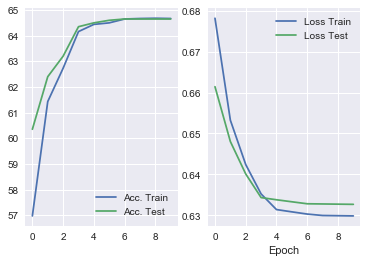

<Figure size 432x288 with 0 Axes>

In [39]:
# test code
EPOCH=10
cnn_config = {"lr": 1e-5, "weight_decay": 1}
acc_train, acc_test, loss_train, loss_test, _ = cnn_train_test(SimpleCNN1layer(32, NUM_CLASSES), TRAIN_FRACTION, cnn_config, CLASS1, CLASS2)
plot(acc_train, acc_test, loss_train, loss_test)

In [8]:
# # run search (serial)
# experiment_logs = list()
# for model_id, m in enumerate(cnn_model_space):
#     for l in lr_space:
#         for w in weight_decay:
#             cnn_config = {"model": model_id, "lr": l, "weight_decay": w}
#             print("Experiment", str(cnn_config))
#             acc_train, acc_test, loss_train, loss_test, _ = cnn_train_test(m, TRAIN_FRACTION, cnn_config, CLASS1, CLASS2)
#             experiment_logs.append((cnn_config, (acc_train, acc_test, loss_train, loss_test)))
#             np.save("grid_search_best_cnn_params.npy", np.array(experiment_logs))

In [9]:
# search space
cnn_model_space = [SimpleCNN1layer(1, NUM_CLASSES), SimpleCNN1layer(
    32, NUM_CLASSES), SimpleCNN2Layers(32, NUM_CLASSES)]  # [0, 1, 2]
lr_space = np.geomspace(1e-6, 1e3, num=10)
weight_decay = np.geomspace(1e-6, 1e3, num=10)

param_dicts = list()
for model_id, m in enumerate(cnn_model_space):
    for l in lr_space:
        for w in weight_decay:
            param_dict = {"model": copy.deepcopy(m), "fraction_of_train_samples": TRAIN_FRACTION, "config": {
                "model": model_id, "lr": l, "weight_decay": w}, "class1": CLASS1, "class2": CLASS2}
            param_dicts.append(param_dict)

In [ ]:
def cnn_train_test_unpack(args):
    return cnn_train_test(**args)

with Pool(int(cpu_count()/torch.get_num_threads())) as p:
    experiment_logs = p.map(cnn_train_test_unpack, param_dicts)
np.save("grid_search_best_cnn_logs.npy", np.array(experiment_logs))

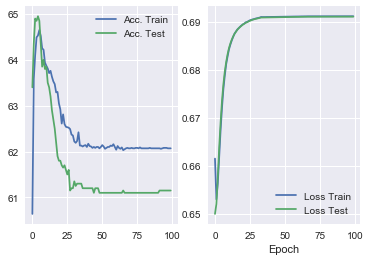

[array([60.64, 63.58, 64.1 , 64.49, 64.53, 64.65, 64.52, 64.25, 64.22,
       63.94, 63.87, 63.81, 63.71, 63.76, 63.63, 63.53, 63.47, 63.29,
       63.3 , 63.05, 62.92, 62.61, 62.81, 62.6 , 62.54, 62.53, 62.52,
       62.49, 62.37, 62.35, 62.22, 62.19, 62.23, 62.42, 62.13, 62.13,
       62.11, 62.13, 62.14, 62.1 , 62.17, 62.12, 62.11, 62.08, 62.1 ,
       62.08, 62.1 , 62.1 , 62.07, 62.1 , 62.14, 62.11, 62.06, 62.08,
       62.1 , 62.1 , 62.13, 62.12, 62.16, 62.1 , 62.04, 62.12, 62.08,
       62.06, 62.09, 62.03, 62.05, 62.07, 62.08, 62.07, 62.07, 62.08,
       62.07, 62.07, 62.08, 62.08, 62.07, 62.09, 62.07, 62.07, 62.07,
       62.07, 62.07, 62.07, 62.08, 62.07, 62.07, 62.07, 62.07, 62.07,
       62.07, 62.07, 62.06, 62.07, 62.08, 62.08, 62.08, 62.07, 62.07,
       62.07])
 array([63.4 , 64.35, 64.9 , 64.85, 64.95, 64.85, 64.35, 63.85, 64.  ,
       63.8 , 63.85, 63.5 , 63.4 , 63.2 , 62.9 , 62.7 , 62.5 , 62.2 ,
       61.9 , 61.8 , 61.8 , 61.7 , 61.65, 61.7 , 61.6 , 61.5 , 61.6 ,
   

<Figure size 432x288 with 0 Axes>

In [13]:
# try
experiment_logs = np.load("grid_search_best_cnn_logs.npy")
test_exp = 117
plot(*experiment_logs[test_exp][:-1])
print(experiment_logs[test_exp])

# acc_train, acc_test, loss_train, loss_test, _ = cnn_train_test(cnn_model_space[experiment_logs[test_exp][4]["model"]], TRAIN_FRACTION, experiment_logs[test_exp][4], CLASS1, CLASS2)
# plot(acc_train, acc_test, loss_train, loss_test)


In [14]:
# # plot all curves
# for acc_train, acc_test, loss_train, loss_test, config in experiment_logs:
#     print(config)
#     plot(acc_train, acc_test, loss_train, loss_test)

In [15]:
model_0, model_1, model_2 = [[i for i in experiment_logs if i[4]["model"] == x] for x in [0, 1, 2]]

In [16]:
# sort based on best test accuracy
model_0 = sorted(model_0, key=lambda x: x[1][-1], reverse=True)
model_1 = sorted(model_1, key=lambda x: x[1][-1], reverse=True)
model_2 = sorted(model_2, key=lambda x: x[1][-1], reverse=True)

In [21]:
top_n = 20

72.8 {'model': 0, 'lr': 0.01, 'weight_decay': 0.001}


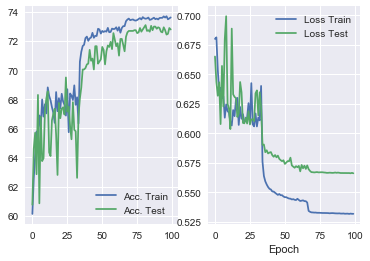

71.55 {'model': 0, 'lr': 0.01, 'weight_decay': 0.01}


<Figure size 432x288 with 0 Axes>

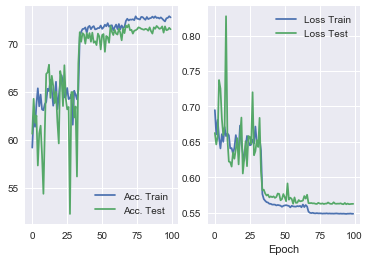

71.4 {'model': 0, 'lr': 0.001, 'weight_decay': 1e-05}


<Figure size 432x288 with 0 Axes>

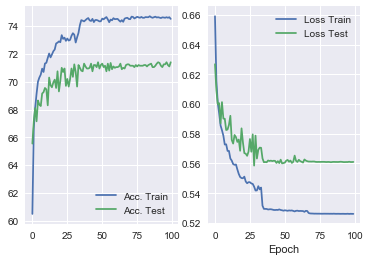

71.3 {'model': 0, 'lr': 0.001, 'weight_decay': 0.001}


<Figure size 432x288 with 0 Axes>

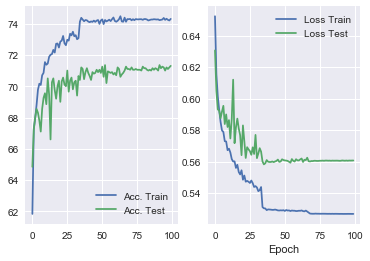

71.25 {'model': 0, 'lr': 0.001, 'weight_decay': 1e-06}


<Figure size 432x288 with 0 Axes>

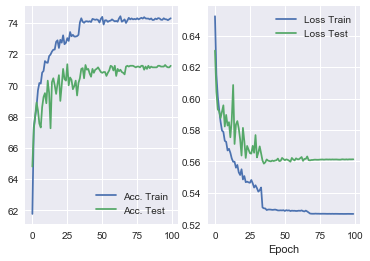

70.65 {'model': 0, 'lr': 0.001, 'weight_decay': 0.0001}


<Figure size 432x288 with 0 Axes>

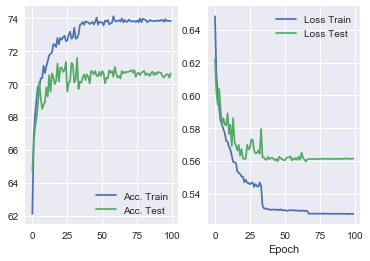

70.65 {'model': 0, 'lr': 0.001, 'weight_decay': 0.01}


<Figure size 432x288 with 0 Axes>

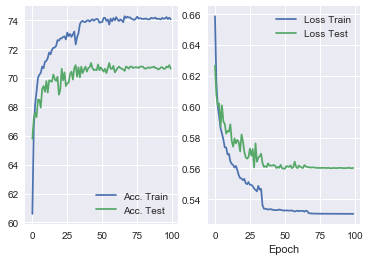

70.35 {'model': 0, 'lr': 0.01, 'weight_decay': 1e-06}


<Figure size 432x288 with 0 Axes>

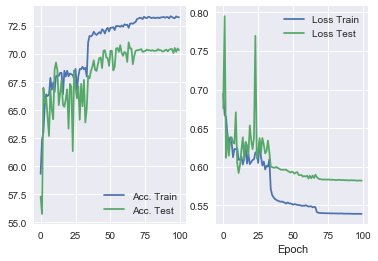

69.8 {'model': 0, 'lr': 0.01, 'weight_decay': 0.0001}


<Figure size 432x288 with 0 Axes>

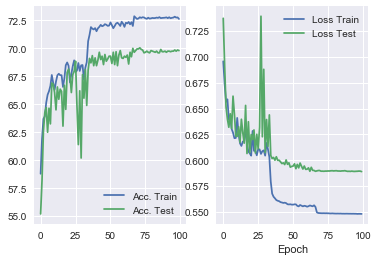

69.75 {'model': 0, 'lr': 0.001, 'weight_decay': 0.1}


<Figure size 432x288 with 0 Axes>

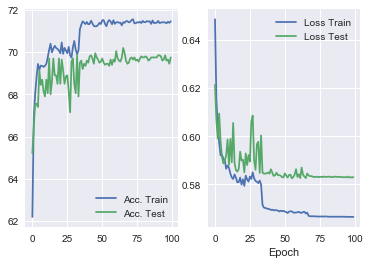

69.1 {'model': 0, 'lr': 0.01, 'weight_decay': 1e-05}


<Figure size 432x288 with 0 Axes>

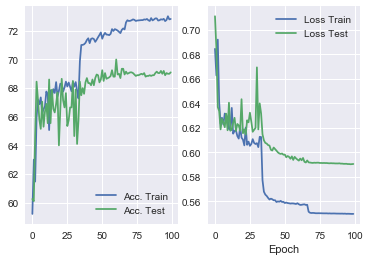

69.0 {'model': 0, 'lr': 0.01, 'weight_decay': 0.1}


<Figure size 432x288 with 0 Axes>

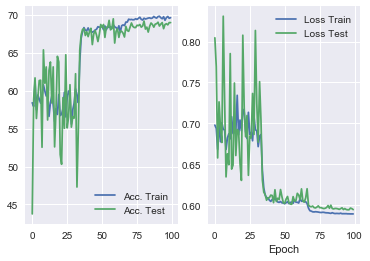

68.5 {'model': 0, 'lr': 0.0001, 'weight_decay': 0.001}


<Figure size 432x288 with 0 Axes>

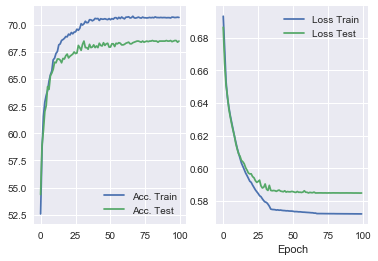

68.35 {'model': 0, 'lr': 0.0001, 'weight_decay': 1e-06}


<Figure size 432x288 with 0 Axes>

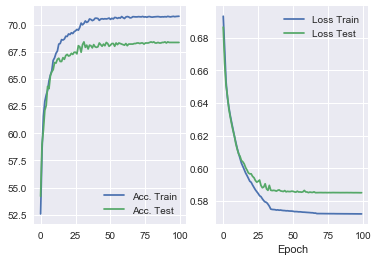

68.35 {'model': 0, 'lr': 0.0001, 'weight_decay': 1e-05}


<Figure size 432x288 with 0 Axes>

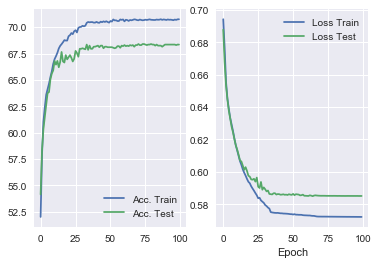

68.25 {'model': 0, 'lr': 0.0001, 'weight_decay': 0.01}


<Figure size 432x288 with 0 Axes>

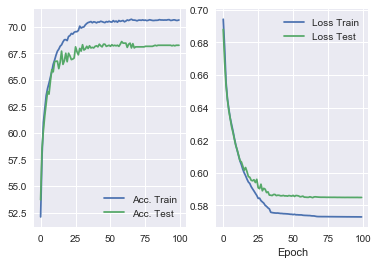

68.15 {'model': 0, 'lr': 0.0001, 'weight_decay': 0.0001}


<Figure size 432x288 with 0 Axes>

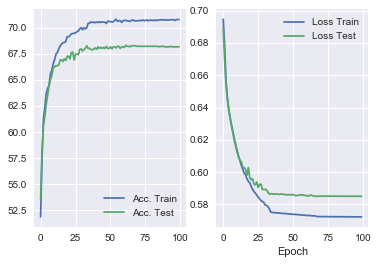

68.05 {'model': 0, 'lr': 0.0001, 'weight_decay': 0.1}


<Figure size 432x288 with 0 Axes>

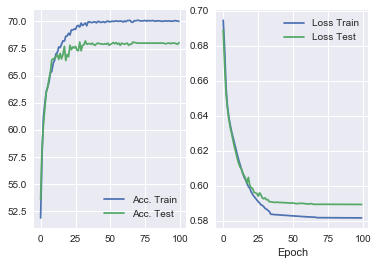

63.0 {'model': 0, 'lr': 0.0001, 'weight_decay': 1.0}


<Figure size 432x288 with 0 Axes>

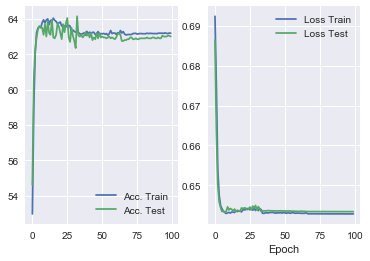

62.9 {'model': 0, 'lr': 0.001, 'weight_decay': 1.0}


<Figure size 432x288 with 0 Axes>

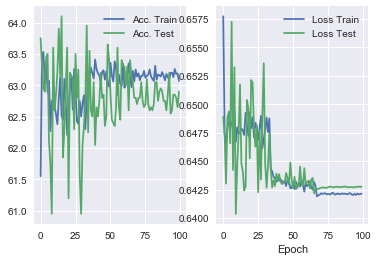

<Figure size 432x288 with 0 Axes>

In [22]:
for acc_train, acc_test, loss_train, loss_test, config in model_0[:top_n]:
    print(acc_test[-1], config)
    plot(acc_train, acc_test, loss_train, loss_test)
# 71.4 {'model': 0, 'lr': 0.001, 'weight_decay': 1e-05}

84.7 {'model': 1, 'lr': 0.001, 'weight_decay': 0.01}


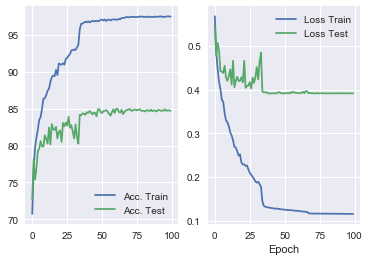

82.85 {'model': 1, 'lr': 0.001, 'weight_decay': 1e-06}


<Figure size 432x288 with 0 Axes>

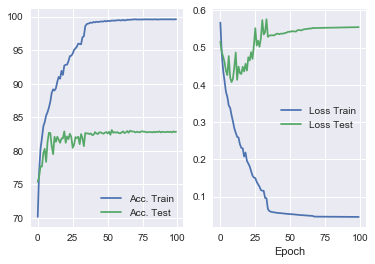

82.75 {'model': 1, 'lr': 0.001, 'weight_decay': 0.1}


<Figure size 432x288 with 0 Axes>

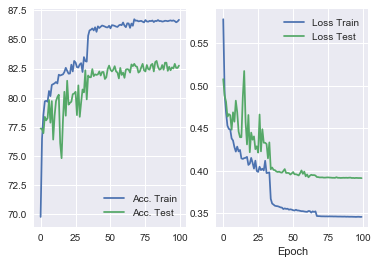

82.7 {'model': 1, 'lr': 0.001, 'weight_decay': 0.0001}


<Figure size 432x288 with 0 Axes>

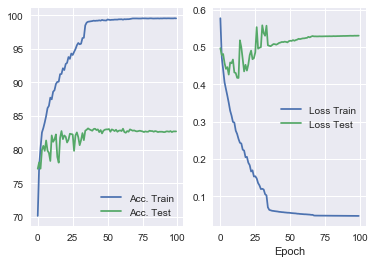

82.7 {'model': 1, 'lr': 0.001, 'weight_decay': 0.001}


<Figure size 432x288 with 0 Axes>

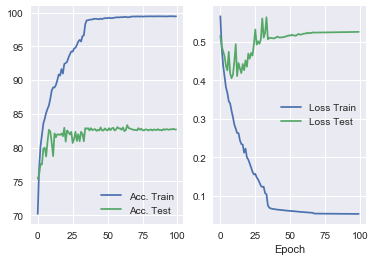

82.65 {'model': 1, 'lr': 0.001, 'weight_decay': 1e-05}


<Figure size 432x288 with 0 Axes>

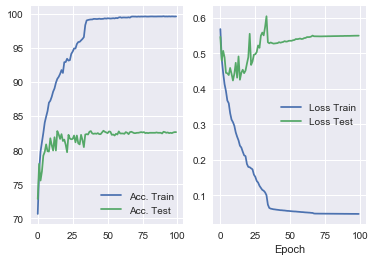

81.55 {'model': 1, 'lr': 0.0001, 'weight_decay': 1e-06}


<Figure size 432x288 with 0 Axes>

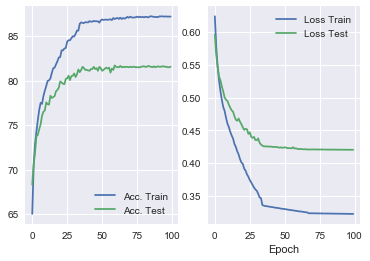

81.55 {'model': 1, 'lr': 0.0001, 'weight_decay': 0.001}


<Figure size 432x288 with 0 Axes>

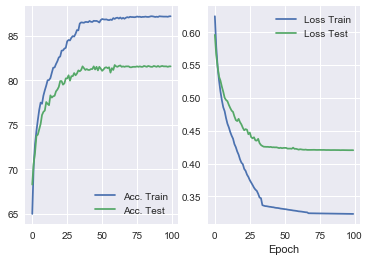

81.5 {'model': 1, 'lr': 0.0001, 'weight_decay': 1e-05}


<Figure size 432x288 with 0 Axes>

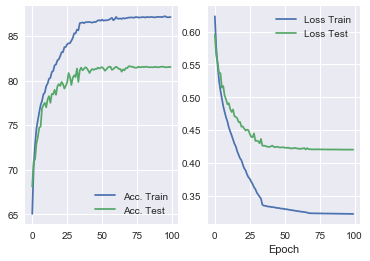

81.45 {'model': 1, 'lr': 0.0001, 'weight_decay': 0.0001}


<Figure size 432x288 with 0 Axes>

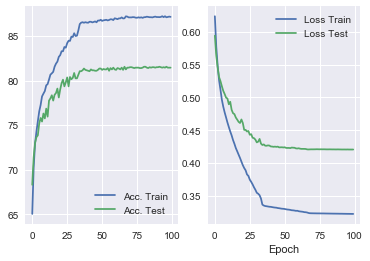

81.25 {'model': 1, 'lr': 0.0001, 'weight_decay': 0.01}


<Figure size 432x288 with 0 Axes>

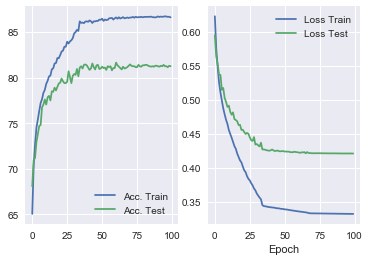

79.85 {'model': 1, 'lr': 0.0001, 'weight_decay': 0.1}


<Figure size 432x288 with 0 Axes>

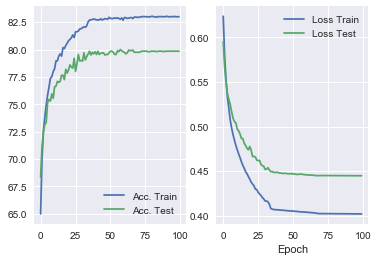

74.05 {'model': 1, 'lr': 1e-05, 'weight_decay': 1e-06}


<Figure size 432x288 with 0 Axes>

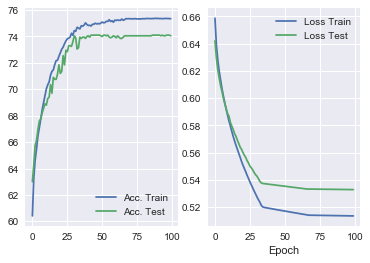

74.05 {'model': 1, 'lr': 1e-05, 'weight_decay': 0.001}


<Figure size 432x288 with 0 Axes>

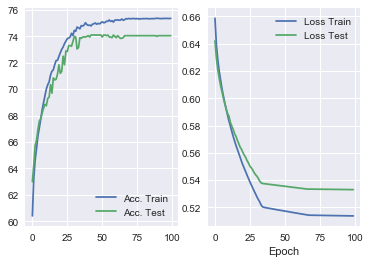

74.0 {'model': 1, 'lr': 1e-05, 'weight_decay': 1e-05}


<Figure size 432x288 with 0 Axes>

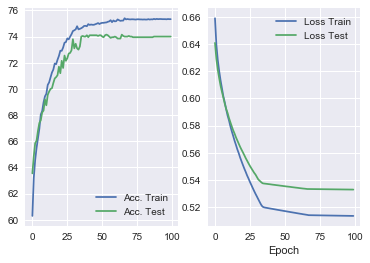

74.0 {'model': 1, 'lr': 1e-05, 'weight_decay': 0.0001}


<Figure size 432x288 with 0 Axes>

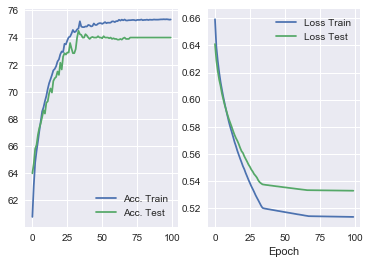

73.95 {'model': 1, 'lr': 1e-05, 'weight_decay': 0.01}


<Figure size 432x288 with 0 Axes>

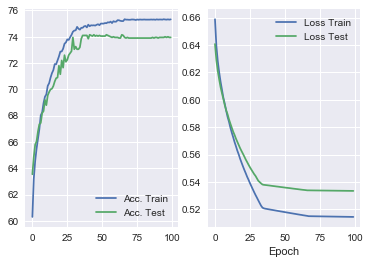

73.55 {'model': 1, 'lr': 1e-05, 'weight_decay': 0.1}


<Figure size 432x288 with 0 Axes>

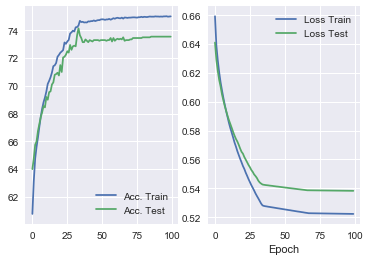

71.5 {'model': 1, 'lr': 0.0001, 'weight_decay': 1.0}


<Figure size 432x288 with 0 Axes>

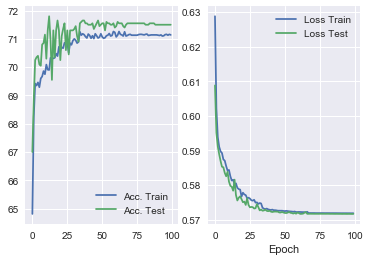

71.3 {'model': 1, 'lr': 0.001, 'weight_decay': 1.0}


<Figure size 432x288 with 0 Axes>

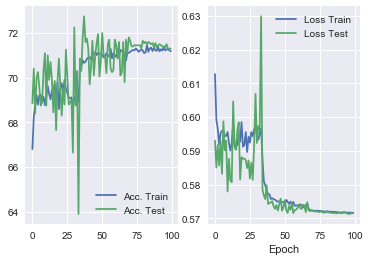

<Figure size 432x288 with 0 Axes>

In [23]:
for acc_train, acc_test, loss_train, loss_test, config in model_1[:top_n]:
    print(acc_test[-1], config)
    plot(acc_train, acc_test, loss_train, loss_test)
# 82.75 {'model': 1, 'lr': 0.001, 'weight_decay': 0.1}

89.1 {'model': 2, 'lr': 0.01, 'weight_decay': 0.01}


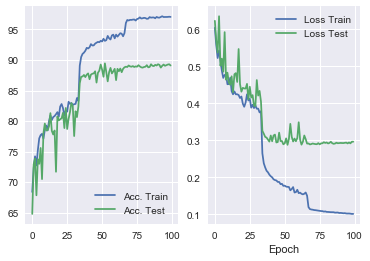

86.65 {'model': 2, 'lr': 0.001, 'weight_decay': 0.01}


<Figure size 432x288 with 0 Axes>

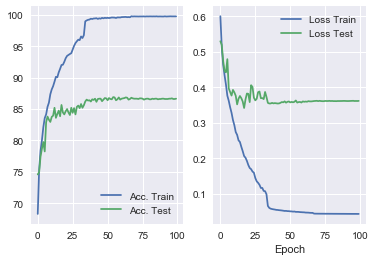

85.8 {'model': 2, 'lr': 0.001, 'weight_decay': 0.001}


<Figure size 432x288 with 0 Axes>

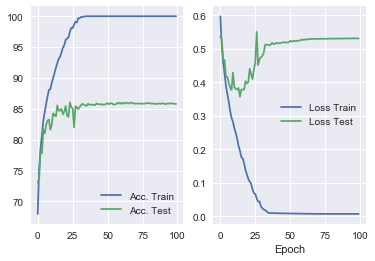

85.75 {'model': 2, 'lr': 0.001, 'weight_decay': 1e-05}


<Figure size 432x288 with 0 Axes>

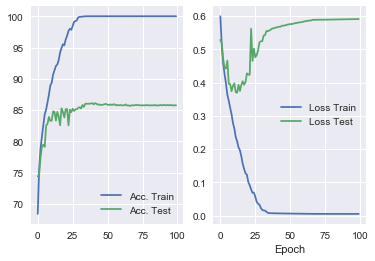

85.7 {'model': 2, 'lr': 0.001, 'weight_decay': 0.1}


<Figure size 432x288 with 0 Axes>

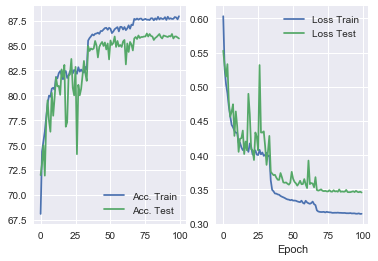

85.65 {'model': 2, 'lr': 0.001, 'weight_decay': 1e-06}


<Figure size 432x288 with 0 Axes>

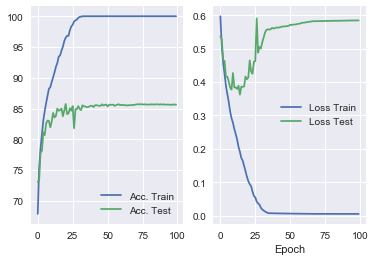

85.35 {'model': 2, 'lr': 0.001, 'weight_decay': 0.0001}


<Figure size 432x288 with 0 Axes>

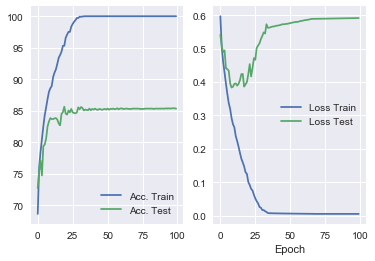

84.35 {'model': 2, 'lr': 0.0001, 'weight_decay': 1e-05}


<Figure size 432x288 with 0 Axes>

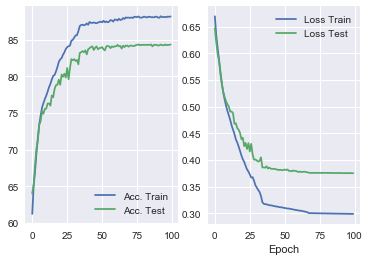

84.2 {'model': 2, 'lr': 0.0001, 'weight_decay': 0.01}


<Figure size 432x288 with 0 Axes>

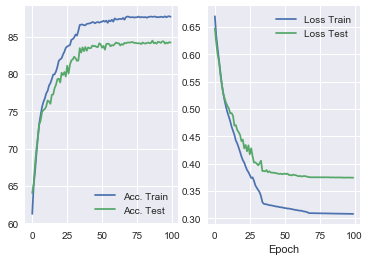

84.2 {'model': 2, 'lr': 0.01, 'weight_decay': 1e-06}


<Figure size 432x288 with 0 Axes>

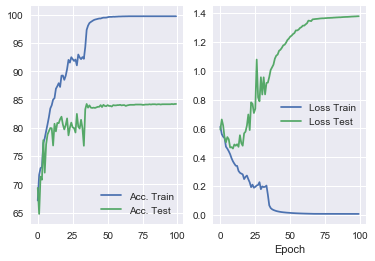

84.05 {'model': 2, 'lr': 0.0001, 'weight_decay': 0.0001}


<Figure size 432x288 with 0 Axes>

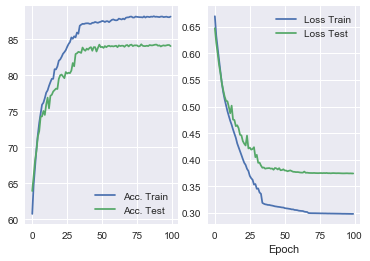

83.85 {'model': 2, 'lr': 0.0001, 'weight_decay': 1e-06}


<Figure size 432x288 with 0 Axes>

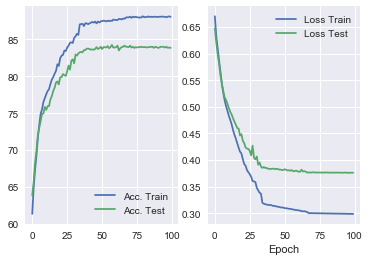

83.85 {'model': 2, 'lr': 0.01, 'weight_decay': 1e-05}


<Figure size 432x288 with 0 Axes>

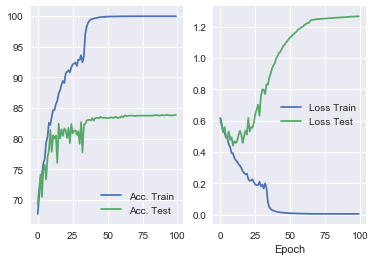

83.8 {'model': 2, 'lr': 0.0001, 'weight_decay': 0.001}


<Figure size 432x288 with 0 Axes>

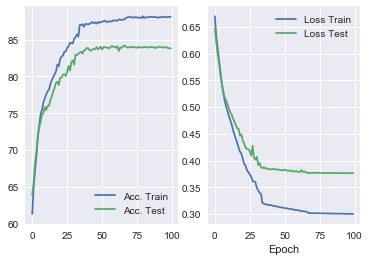

83.35 {'model': 2, 'lr': 0.01, 'weight_decay': 0.0001}


<Figure size 432x288 with 0 Axes>

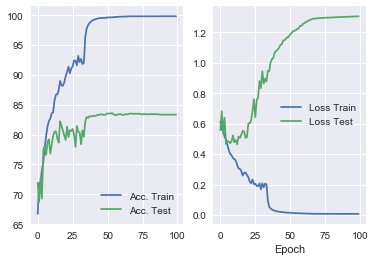

83.3 {'model': 2, 'lr': 0.01, 'weight_decay': 0.001}


<Figure size 432x288 with 0 Axes>

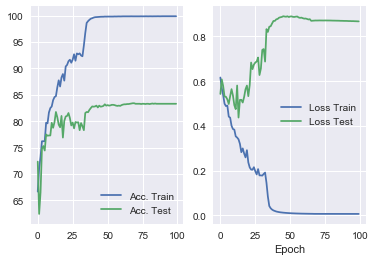

82.95 {'model': 2, 'lr': 0.0001, 'weight_decay': 0.1}


<Figure size 432x288 with 0 Axes>

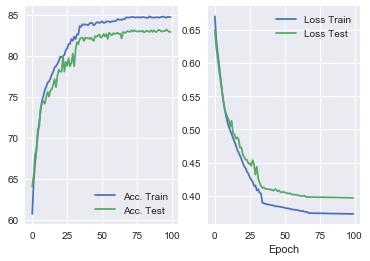

69.75 {'model': 2, 'lr': 1e-05, 'weight_decay': 1e-05}


<Figure size 432x288 with 0 Axes>

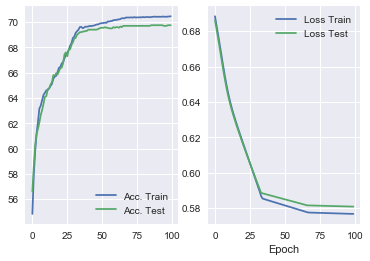

69.7 {'model': 2, 'lr': 1e-05, 'weight_decay': 1e-06}


<Figure size 432x288 with 0 Axes>

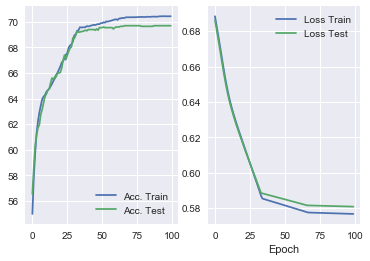

69.7 {'model': 2, 'lr': 1e-05, 'weight_decay': 0.0001}


<Figure size 432x288 with 0 Axes>

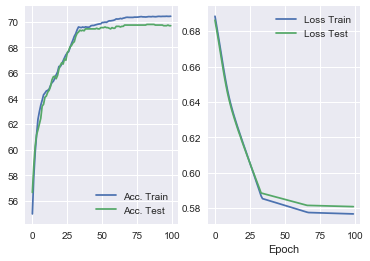

<Figure size 432x288 with 0 Axes>

In [24]:
for acc_train, acc_test, loss_train, loss_test, config in model_2[:top_n]:
    print(acc_test[-1], config)
    plot(acc_train, acc_test, loss_train, loss_test)
# 89.1 {'model': 2, 'lr': 0.01, 'weight_decay': 0.01}

N/A% (0 of 99) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Experiment: {'model': 2, 'lr': 0.01, 'weight_decay': 0.01}


100% (99 of 99) |########################| Elapsed Time: 0:01:23 ETA:  00:00:00

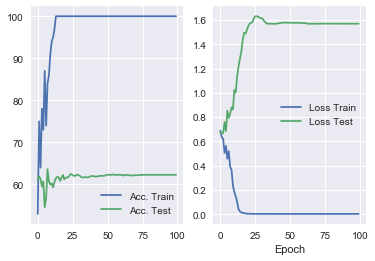

<Figure size 432x288 with 0 Axes>

In [27]:
# test
temp_config = {'model': 2, 'lr': 0.01, 'weight_decay': 0.01}
acc_train, acc_test, loss_train, loss_test, _ = cnn_train_test(SimpleCNN2Layers(32, NUM_CLASSES), 0.01, temp_config, CLASS1, CLASS2)
plot(acc_train, acc_test, loss_train, loss_test)